In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rc('font', family="serif")
plt.rc('font', size=16)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
plt.rc('figure', figsize=(6,4)) 

In [3]:
from jax import (
    jit as jjit,
    numpy as jnp,
    vmap,
    grad,
    random as jran,
    value_and_grad,
)

import numpy as np

# Introduction to Gradient Descent

Gradient Descent is an optimization algorithm used to minimize the cost function $J(\theta)$ in machine learning, neural networks or life in general. The goal is to find the optimal values of parameters $\theta$ that minimize the cost function.

The update rule for Gradient Descent is:

$$
\theta := \theta - \alpha \nabla J(\theta)
$$

Where:
- $\theta$ represents the model parameters,
- $\alpha$ is the learning rate (a small positive value),
- $\nabla J(\theta)$ is the gradient of the cost function with respect to $\theta$.

The gradient $\nabla J(\theta)$ tells us the direction in which the cost function is increasing the fastest. By moving in the opposite direction of the gradient (i.e., subtracting the gradient from $\theta$), we iteratively minimize the cost function.

### Types of Gradient Descent:
- **Batch Gradient Descent**: Uses the entire dataset to compute the gradient.
- **Stochastic Gradient Descent (SGD)**: Uses a single data point to compute the gradient.
- **Mini-batch Gradient Descent**: Uses a small subset (mini-batch) of the dataset to compute the gradient.

The choice of learning rate $\alpha$ is crucial: if it's too large, we might overshoot the minimum; if it's too small, convergence can be very slow.


We will once again use our little toy model for SN light curves.

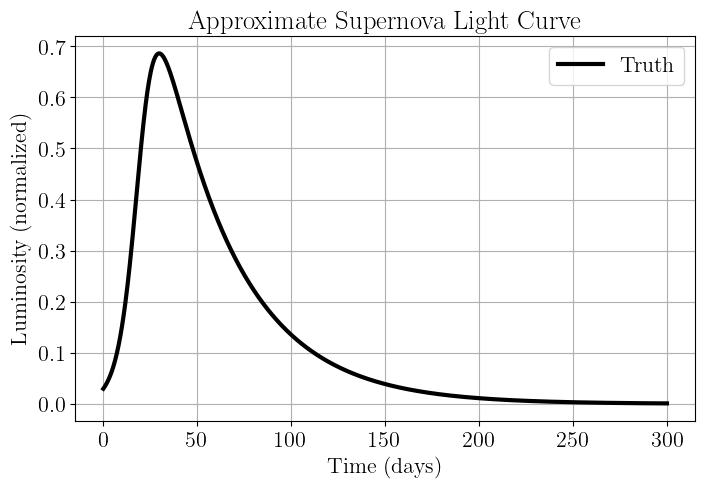

In [4]:
# Smooth logistic function for transition
def smooth_transition(t, t_half, width=5.0):
    """Smooth transition function using logistic sigmoid."""
    return 1 / (1 + jnp.exp(-(t - t_half) / width))

# Type Ia Supernova Light Curve (Smooth Peak + Exponential Decline)
@jjit
def type_ia_lc(t, t_peak=20.0, L_peak=1.0, tau_decay=40.0, width=5.0):
    """Smooth Type Ia supernova light curve using JAX."""
    rise = L_peak * smooth_transition(t, t_peak, width)  # Smooth rise
    decline = L_peak * jnp.exp(-(t - t_peak) / tau_decay)  # Exponential decline
    return rise * decline

# Time range (0 to 300 days)
t = jnp.linspace(0, 300, 1000)

# Compute light curves
L_ia = type_ia_lc(t)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_ia, label="Truth", linestyle='-', color='k', lw=3)

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

In this example, we have four model parameters: $\theta = \{ t_{\rm peak}, L_{\rm peak}, \tau_{\rm decay}, \sigma \}$.

We start by defining our target data, using our default parameters, and some initial guess `p_init`.

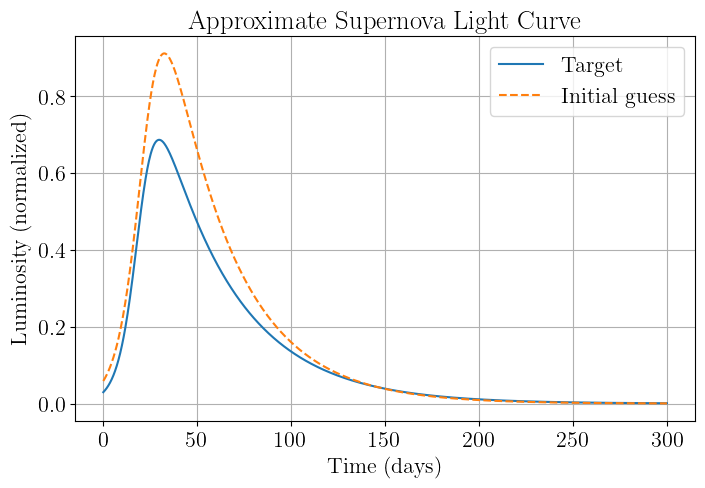

In [5]:
# default values for (t_peak, L_peak, tau_decay, width)
target_vals = (20.0, 1.0, 40.0, 5.0)

# Target data
L_target = type_ia_lc(t, *target_vals)

# initial guess values for (t_peak, L_peak, tau_decay, width)
p_init = (23.0, 1.2, 35.0, 6.0)
L_init = type_ia_lc(t, *p_init)


# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_target, label="Target", linestyle='-')
plt.plot(t, L_init, label="Initial guess", linestyle='--')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()


## Defining our loss function

In [6]:
@jjit
def loss_function(params, loss_data):
    tarr, L_target = loss_data
    L_estimate = type_ia_lc(t, *params)
    return jnp.sum((L_estimate - L_target)**2) # Mean squared error loss.

loss_value_and_grad = jjit(value_and_grad(loss_function, argnums=0))

## Descending our gradient

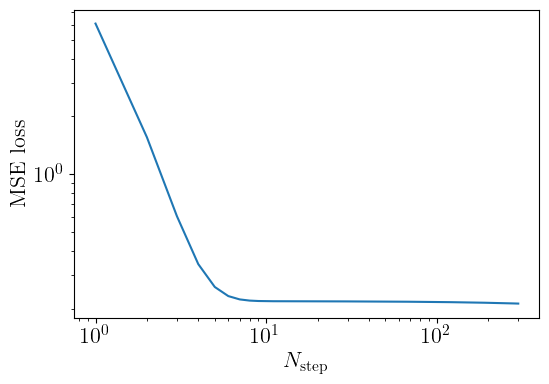

In [7]:
loss_data = (t, L_target)

learning_rate = 0.001
n_steps = 300

p = np.copy(p_init)
collector = []
for istep in range(n_steps):
    loss, grads = loss_value_and_grad(p, loss_data)
    p = p - learning_rate * np.array(grads)
    collector.append([loss, p])


p_best = np.array(collector[-1][1])
loss_history = np.array([x[0] for x in collector])

fig, ax = plt.subplots(1, 1)
__=ax.plot(np.arange(len(loss_history))+1, loss_history)

xlabel = ax.set_xlabel(r'$N_{\rm step}$')
ylabel = ax.set_ylabel(r'MSE loss')
ax.set_yscale('log')
ax.set_xscale('log')

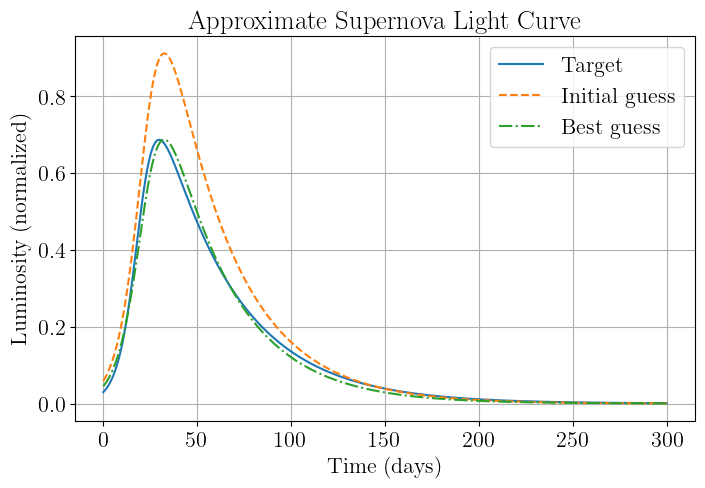

In [8]:
L_best = type_ia_lc(t, *p_best)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_target, label="Target", linestyle='-')
plt.plot(t, L_init, label="Initial guess", linestyle='--')
plt.plot(t, L_best, label="Best guess", linestyle='-.')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

Not bad, but we can do better. For example, we can use Adam's stochastic gradient descent algorithm!

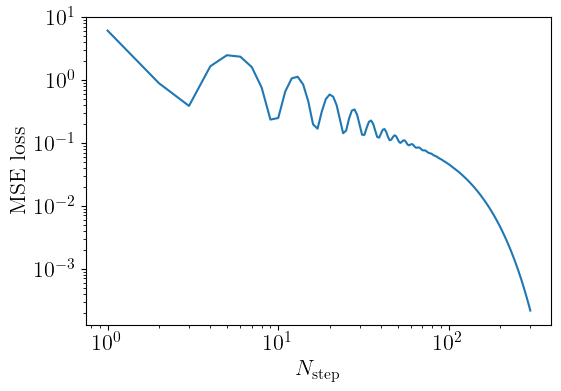

In [9]:
from jax.example_libraries.optimizers import adam

# Initialize the Adam optimizer
learning_rate = 0.1
optimizer_init, optimizer_update, get_params = adam(learning_rate)

# Initialize the optimizer state
opt_state = optimizer_init(p_init)
p = get_params(opt_state)

# Number of optimization steps
num_steps = 300

collector = []
# Perform optimization using Adam
for step in range(num_steps):

    
    loss, grads = loss_value_and_grad(p, loss_data)
    
    # Update the parameters using the gradient and Adam optimizer
    opt_state = optimizer_update(step, grads, opt_state)
    
    # Get the current value of the parameters
    p = get_params(opt_state)
    collector.append([loss, p])


p_best = np.array(collector[-1][1])
loss_history = np.array([x[0] for x in collector])

fig, ax = plt.subplots(1, 1)
__=ax.plot(np.arange(len(loss_history))+1, loss_history)

xlabel = ax.set_xlabel(r'$N_{\rm step}$')
ylabel = ax.set_ylabel(r'MSE loss')
ax.set_yscale('log')
ax.set_xscale('log')

Now we obtain a nearly perfect fit!

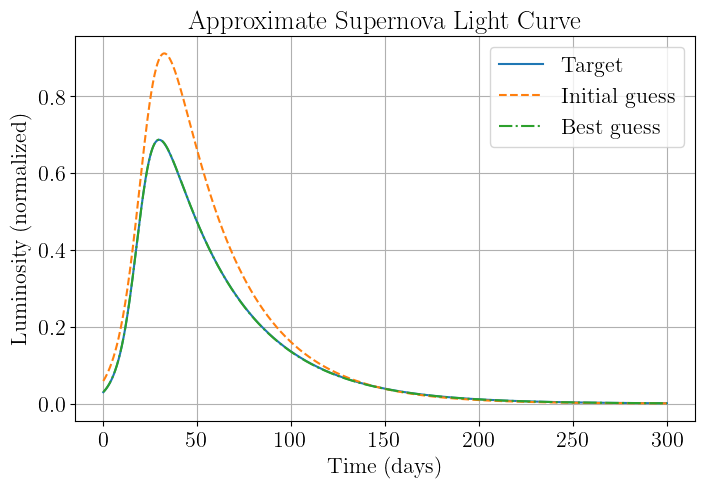

In [10]:
L_best = type_ia_lc(t, *p_best)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_target, label="Target", linestyle='-')
plt.plot(t, L_init, label="Initial guess", linestyle='--')
plt.plot(t, L_best, label="Best guess", linestyle='-.')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

It works even if we use a wilder initial guess!

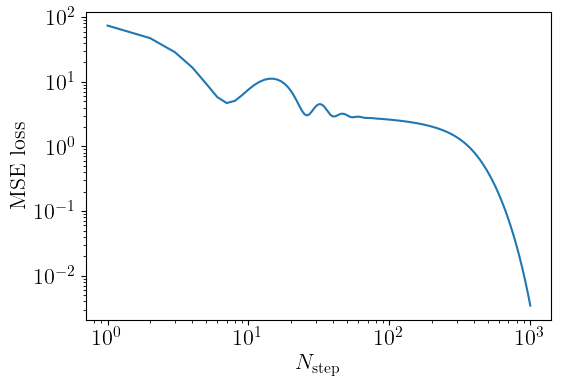

In [11]:
# wilder initial guess
p_init = (40.0, 1.7, 20.0, 8.0)
L_init = type_ia_lc(t, *p_init)

# Initialize the Adam optimizer
learning_rate = 0.1
optimizer_init, optimizer_update, get_params = adam(learning_rate)

# Initialize the optimizer state
opt_state = optimizer_init(p_init)
p = get_params(opt_state)

# Number of optimization steps
num_steps = 1_000

collector = []
# Perform optimization using Adam
for step in range(num_steps):

    
    loss, grads = loss_value_and_grad(p, loss_data)
    
    # Update the parameters using the gradient and Adam optimizer
    opt_state = optimizer_update(step, grads, opt_state)
    
    # Get the current value of the parameters
    p = get_params(opt_state)
    collector.append([loss, p])


p_best = np.array(collector[-1][1])
loss_history = np.array([x[0] for x in collector])

fig, ax = plt.subplots(1, 1)
__=ax.plot(np.arange(len(loss_history))+1, loss_history)

xlabel = ax.set_xlabel(r'$N_{\rm step}$')
ylabel = ax.set_ylabel(r'MSE loss')
ax.set_yscale('log')
ax.set_xscale('log')

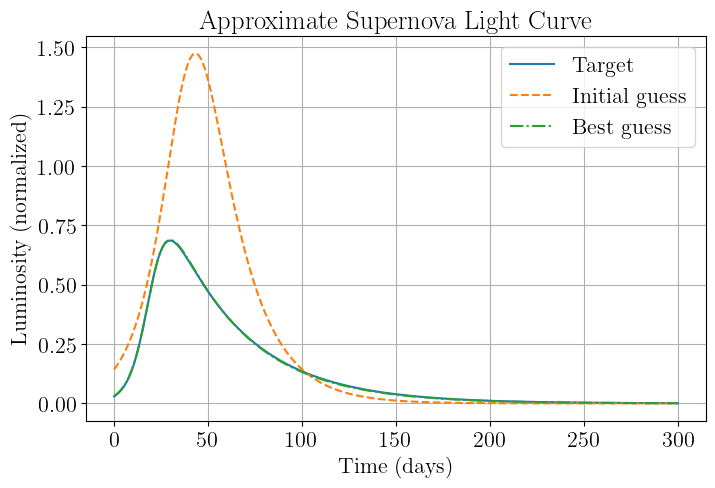

In [12]:
L_best = type_ia_lc(t, *p_best)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_target, label="Target", linestyle='-')
plt.plot(t, L_init, label="Initial guess", linestyle='--')
plt.plot(t, L_best, label="Best guess", linestyle='-.')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

We can also show a few intermediate steps of the gradient descent, using `vmap` to calculate the light curves for a bunch of steps:

In [13]:
type_ia_lc_vmap = vmap(type_ia_lc, in_axes=(None, 0, 0, 0, 0))

# p_descent = np.array([np.array(collector[i][1]) for i in np.linspace(0,999, 30).astype(int)])
steps = np.concatenate(
    (np.arange(0, 50, 1).astype(int),
    np.logspace(np.log10(51),np.log10(999), 10).astype(int))
)
p_descent = np.array([np.array(collector[i][1]) for i in steps])

L_descent = type_ia_lc_vmap(t, *p_descent.T)
print(L_descent.shape)

(60, 1000)


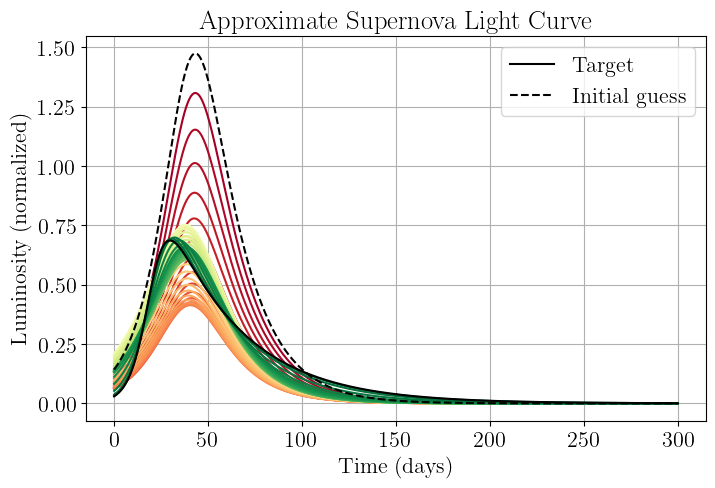

In [14]:
L_best = type_ia_lc(t, *p_best)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))


cmap = plt.get_cmap("RdYlGn")
colors = cmap(np.linspace(0,1,len(L_descent)))
for i in range(len(L_descent)):
    plt.plot(t, L_descent[i], linestyle='-', color=colors[i])

plt.plot(t, L_target, label="Target", linestyle='-', color='k')
plt.plot(t, L_init, label="Initial guess", linestyle='--', color='k')
# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()